In [ ]:
! gdown 1X1jZgrRaVH-h0xX3k8cSzT0kumIVlmwx #sarc_emojis_1000.csv
! gdown 1--LLxkODAryG3TgUHrcggfrYoXnr9UFe #not_sarc_emojis_1000.csv

Downloading...
From: https://drive.google.com/uc?id=1X1jZgrRaVH-h0xX3k8cSzT0kumIVlmwx
To: /content/sarc_emojis_1000.csv
100% 1.60M/1.60M [00:00<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--LLxkODAryG3TgUHrcggfrYoXnr9UFe
To: /content/not_sarc_emojis_1000.csv
100% 1.68M/1.68M [00:00<00:00, 173MB/s]


In [ ]:
!pip install pandas scikit-learn

In [ ]:
!pip install tweetnlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2

In [ ]:
import tweetnlp
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import torch

# Load data
df1 = pd.read_csv('sarc_emojis_1000.csv')
df2 = pd.read_csv('not_sarc_emojis_1000.csv')

# Combine datasets
df = pd.concat([df1, df2], ignore_index=True)
texts = df['text'].astype(str).str.lower()
labels = df['label']

# Create a new dataframe with 'text' and 'label' columns
data = pd.DataFrame({'text': texts, 'label': labels})

# Encode labels as integers
label2id = {label: i for i, label in enumerate(data['label'].unique())}
id2label = {i: label for label, i in label2id.items()}
data['label'] = data['label'].map(label2id)

# Split data into training and testing sets
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-emoji')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-emoji', num_labels=len(label2id))

# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# Define data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)

# Fine-tune the model
trainer.train()

# Save the model and tokenizer
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')

# Evaluation
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('./fine_tuned_model')
model = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_model')

# Tokenize the test data
inputs = tokenizer(list(val_df['text']), return_tensors="pt", padding=True, truncation=True)

# Perform predictions
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).numpy()

# Convert predictions and labels back to original labels
predicted_labels = [id2label[p] for p in predictions]
true_labels = [id2label[l] for l in val_df['label']]

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 32000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6000


Epoch,Training Loss,Validation Loss


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safel

Epoch,Training Loss,Validation Loss
1,2.674100,2.632820
2,2.412500,2.591250
3,2.086700,2.744184


Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3000/config.json
Model weights saved in ./results/checkpoint-3000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3500
Configuration saved in ./results/checkpoint-3500/config.json
Model weights saved in ./results/checkpoint-3500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-4000
Configuration saved in ./results/checkpoint-4000/config.json
Model weights saved in ./results/checkpoint-4000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can sa

In [ ]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

# שלב 1: טעינת המודל והטוקניזר השמורים
model_path = './fine_tuned_model'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# שלב 2: הכנת נתוני הבדיקה
# טען מחדש את נתוני הבדיקה
df1 = pd.read_csv('sarc_emojis_1000.csv')
df2 = pd.read_csv('not_sarc_emojis_1000.csv')
df = pd.concat([df1, df2], ignore_index=True)
texts = df['text'].astype(str).str.lower()
labels = df['label']
data = pd.DataFrame({'text': texts, 'label': labels})

# מיפוי התוויות (labels) למספרים
label2id = {label: i for i, label in enumerate(data['label'].unique())}
id2label = {i: label for label, i in label2id.items()}
data['label'] = data['label'].map(label2id)

# חלוקת הנתונים לנתוני אימון ובדיקה (כמו שנעשה קודם)
_, val_df = train_test_split(data, test_size=0.2, random_state=42)
val_dataset = Dataset.from_pandas(val_df)

# שלב 3: ביצוע ניבויים על נתוני הבדיקה
# טוקניזציה של נתוני הבדיקה
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

val_dataset = val_dataset.map(tokenize, batched=True)

# קבלת התכונות והתגובות מ-dataset
inputs = tokenizer(list(val_df['text']), return_tensors="pt", padding=True, truncation=True, max_length=128)
labels = torch.tensor(val_df['label'].values)

# ביצוע ניבויים
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).numpy()

# שלב 4: חישוב מדדי הביצועים
predicted_labels = [id2label[p] for p in predictions]
true_labels = [id2label[l] for l in val_df['label']]

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# הצגת התוצאות
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Accuracy: 0.2186
F1 Score: 0.2067
Precision: 0.2050
Recall: 0.2186
Confusion Matrix:
[[104  15  10  17  11   6  23   9  14  47   9   6   4   7  26  20  26  14
    3   4]
 [ 11 115  31  45   4  10  12   5  16  43   4   9  13   5  16   7  17  15
   10   2]
 [  5  51  98  34   8  16  14  12  29  28   8   7   9  10  15  12  21   8
   15   8]
 [ 17  34  26 186   3   5  12   4   3  20   3   5   6   1  12   9  15  12
    9   2]
 [ 15  24  26  19  17  20  22   9  32  25  13   9  10   5  21  35  21  39
   16  17]
 [  9  10  14   9   7  94   7   7  42   7  16  14  17  35  11  26  17  25
   29  31]
 [ 22  19  19  17  16   7  58  11  23  50   7  13  12   8  30  18  31  28
    7   8]
 [ 31  26  19  16  11  13  42  19  26  31   7  13   7   9  21  24  24  20
   13  23]
 [ 13  21  24   8   8  35   0   5  86  19  17   5   4   9   5  44  11   7
   34  33]
 [ 41  28  23  16   8  13  38   9  28  96   9   6   8   4  22   8  23  12
    6  12]
 [ 14  20  13  10  11  27   6   3  42  13  36  13  14  29  29  35

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/d

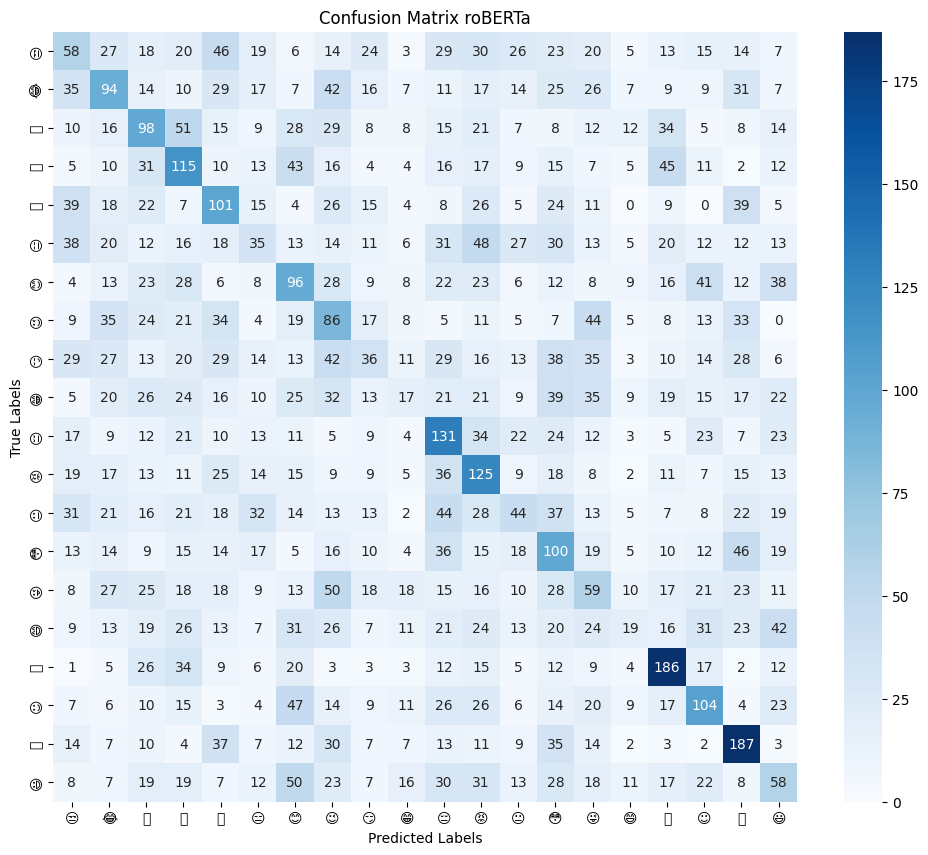

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels based on the mapping
true_labels_mapped = [id2label[l] for l in val_df['label']]
predicted_labels_mapped = [id2label[p] for p in predictions]

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels_mapped, predicted_labels_mapped, labels=list(id2label.values()))

# Display confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=list(id2label.values()), yticklabels=list(id2label.values()), cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix roBERTa')
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Define labels based on the mapping
true_labels_mapped = [id2label[l] for l in val_df['label']]
predicted_labels_mapped = [id2label[p] for p in predictions]

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels_mapped, predicted_labels_mapped, labels=list(id2label.values()))

# Extract indices of FP and FN
fp_indices = []
fn_indices = []

for true_label_idx in range(conf_matrix.shape[0]):
    for pred_label_idx in range(conf_matrix.shape[1]):
        if true_label_idx != pred_label_idx:
            # False Positive (predicted as pred_label_idx but actually true_label_idx)
            if conf_matrix[true_label_idx, pred_label_idx] > 0:
                for idx in range(len(true_labels_mapped)):
                    if true_labels_mapped[idx] == list(id2label.values())[true_label_idx] and predicted_labels_mapped[idx] == list(id2label.values())[pred_label_idx]:
                        fp_indices.append(idx)
                        break
            # False Negative (predicted as true_label_idx but actually pred_label_idx)
            if conf_matrix[true_label_idx, pred_label_idx] > 0:
                for idx in range(len(true_labels_mapped)):
                    if true_labels_mapped[idx] == list(id2label.values())[true_label_idx] and predicted_labels_mapped[idx] == list(id2label.values())[pred_label_idx]:
                        fn_indices.append(idx)
                        break

# Extract examples of FP and FN
fp_examples = val_df.iloc[fp_indices].head(3)
fn_examples = val_df.iloc[fn_indices].head(3)

# Display examples
print("False Positives Examples:")
print(fp_examples[['text', 'label']])
print("\nFalse Negatives Examples:")
print(fn_examples[['text', 'label']])


False Positives Examples:
                                                    text  label
314    roman reigns, steroids? noooo  didn’t see that...      0
20728  ok then, i see people playing cod so i know it...      0
953    ordered a large sweet tea at and they filled m...      0

False Negatives Examples:
                                                    text  label
314    roman reigns, steroids? noooo  didn’t see that...      0
20728  ok then, i see people playing cod so i know it...      0
953    ordered a large sweet tea at and they filled m...      0


In [ ]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import numpy as np

# Load the saved model and tokenizer
model_path = './fine_tuned_model'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load test data
df1 = pd.read_csv('sarc_emojis_1000.csv')
df2 = pd.read_csv('not_sarc_emojis_1000.csv')
df = pd.concat([df1, df2], ignore_index=True)
texts = df['text'].astype(str).str.lower()
labels = df['label']
data = pd.DataFrame({'text': texts, 'label': labels})

# Map labels to numbers
label2id = {label: i for i, label in enumerate(data['label'].unique())}
id2label = {i: label for label, i in label2id.items()}
data['label'] = data['label'].map(label2id)

# Split the data into training and test sets
_, val_df = train_test_split(data, test_size=0.2, random_state=42)
val_dataset = Dataset.from_pandas(val_df)

# Tokenize the test data
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

val_dataset = val_dataset.map(tokenize, batched=True)

# Get features and labels from the dataset
inputs = tokenizer(list(val_df['text']), return_tensors="pt", padding=True, truncation=True, max_length=128)
labels = torch.tensor(val_df['label'].values)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).numpy()

# Create a dataframe with true and predicted labels
val_df['true_label'] = val_df['label'].apply(lambda x: id2label[x])
val_df['predicted_label'] = [id2label[p] for p in predictions]

# Initialize dictionaries to store examples
fp_examples = {label: [] for label in id2label.values()}
fn_examples = {label: [] for label in id2label.values()}

# Collect FP and FN examples
for idx, row in val_df.iterrows():
    true_label = row['true_label']
    predicted_label = row['predicted_label']
    if true_label != predicted_label:
        # False Positive: predicted_label but actually true_label
        if len(fp_examples[predicted_label]) < 3:
            fp_examples[predicted_label].append(row['text'])
        # False Negative: true_label but predicted as something else
        if len(fn_examples[true_label]) < 3:
            fn_examples[true_label].append(row['text'])

# Create a dataframe for FP and FN examples
fp_df = pd.DataFrame([(label, text) for label, texts in fp_examples.items() for text in texts], columns=['Emoji', 'False Positive Examples'])
fn_df = pd.DataFrame([(label, text) for label, texts in fn_examples.items() for text in texts], columns=['Emoji', 'False Negative Examples'])

# Save the examples to an Excel file
with pd.ExcelWriter('error_analysis_roBERTa.xlsx', engine='openpyxl') as writer:
    fp_df.to_excel(writer, sheet_name='False Positives', index=False)
    fn_df.to_excel(writer, sheet_name='False Negatives', index=False)

print("Examples saved to error_analysis.xlsx file.")


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Examples saved to error_analysis.xlsx file.
